# Setting Up Modules and Constants

In [1]:
# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import os
from tensorflow.keras import layers
import time
import kaggle

/Users/sargunsinghbhatti/Library/CloudStorage/OneDrive-UniversityofWaterloo/Documents/GitHub/harmful-brain-activity/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
PATH = 'data/'
TRAIN_CSV = PATH + 'train.csv'
TEST_CSV = PATH + 'test.csv'
SUBMISSION_CSV = PATH + 'submission.csv'
TEST_EEGS = PATH + 'test_eegs/'
TRAIN_EEGS = PATH + 'train_eegs/'
TEST_SPECTROGRAMS = PATH + 'test_spectrograms/'
TRAIN_SPECTROGRAMS = PATH + 'train_spectrograms/'

# Inputing a Sample Train X

In [3]:
# Reading from the train csv
train_data = pd.read_csv(TRAIN_CSV)

# Getting the first eeg and spectrogram data id respectively
eeg_id = train_data['eeg_id'][0]
spectrogram_id = train_data['spectrogram_id'][0]

# Getting the first label offset seconds for eeg and spectrogram respectively
eeg_label_offset_seconds = train_data['eeg_label_offset_seconds'][0]
spectrogram_label_offset_seconds = train_data['spectrogram_label_offset_seconds'][0]

# Defining the duration time for eeg and spectrogram respectively
eeg_duration = 10000
spectrogram_duration = 300

# Reading the eeg and spectrogram data with the aforementioned ids
eeg = pd.read_parquet(TRAIN_EEGS + f'{eeg_id}.parquet')
spectrogram = pd.read_parquet(TRAIN_SPECTROGRAMS + f'{spectrogram_id}.parquet')

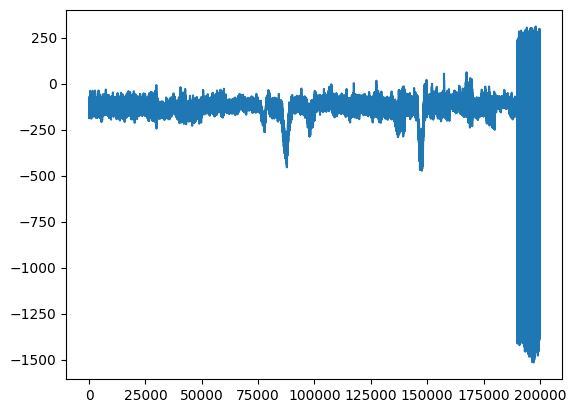

In [4]:
# Takes the 50 second sample of the eeg data
eeg = eeg.loc[eeg_label_offset_seconds : eeg_label_offset_seconds + eeg_duration - 1,]
eeg = eeg.to_numpy().T.flatten()
eeg = eeg.tolist()

# Each row represents a time point with all the node.
# Each column represents a node at all time points one by one.
plt.plot(eeg)

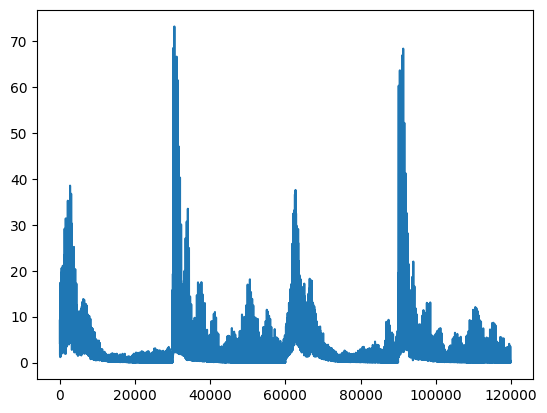

In [5]:
# Takes the 10 minute sample of the spectrogram data
spectrogram = spectrogram.loc[spectrogram_label_offset_seconds : spectrogram_label_offset_seconds + spectrogram_duration - 1,]
spectrogram = spectrogram.to_numpy()[:,1:].T.flatten() # Removing the time column
spectrogram = spectrogram.tolist()

# Each row represents a time point with all the frequency.
# Each column represents a frequency at all time points one by one.
plt.plot(spectrogram)

In [6]:
# Votes for each class
seizure_vote = train_data['seizure_vote'][0]
lpd_vote = train_data['lpd_vote'][0]
gpd_vote = train_data['gpd_vote'][0]
lrda_vote = train_data['lrda_vote'][0]
grda_vote = train_data['grda_vote'][0]
other_vote = train_data['other_vote'][0]

In [7]:
# Defining the new X_train and Y_train
y_train = [seizure_vote, lpd_vote, gpd_vote, lrda_vote, grda_vote, other_vote]
y_train = np.array(y_train)


x_train = eeg + spectrogram
x_train = np.array(x_train)

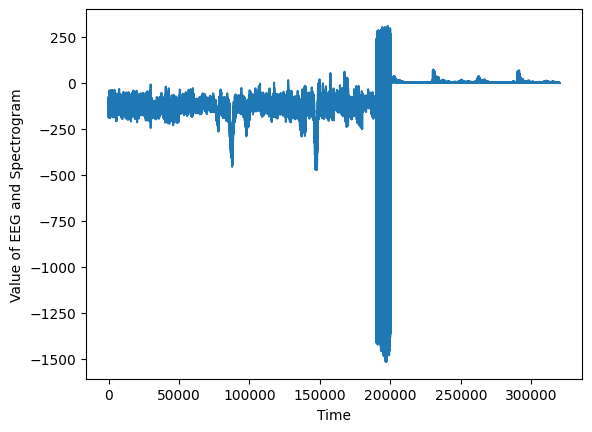

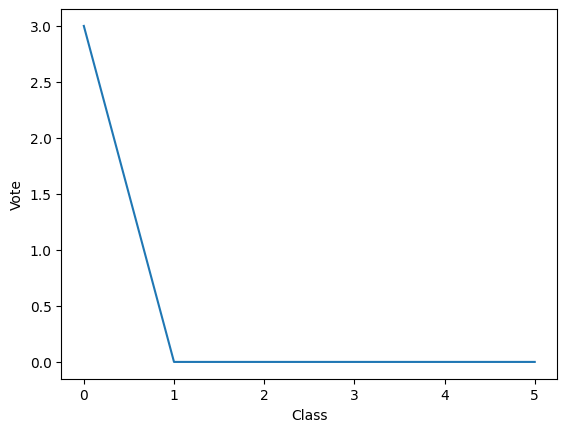

In [8]:
plt.plot(x_train)
plt.xlabel('Time')
plt.ylabel('Value of EEG and Spectrogram')
plt.show()
plt.plot(y_train)
plt.xlabel('Class')
plt.ylabel('Vote')
plt.show()

In [9]:
print("X train's size: ", x_train.size)
print("Y train's size: ", y_train.size)

print("X train's shape: ", x_train.shape)
print("Y train's shape: ", y_train.shape)

X train's size:  320000
Y train's size:  6
X train's shape:  (320000,)
Y train's shape:  (6,)


# Getting all the train eeg and spectrogram data

In [10]:
def get_input_data(length=100):
    # Reading from the train csv
    train_data = pd.read_csv(TRAIN_CSV)

    # Defining the duration time for eeg and spectrogram respectively
    eeg_duration = 10000
    spectrogram_duration = 300

    # Defining the unit of measurment per second for eeg and spectrogram respectively
    eeg_unit = 200  # 200 units takes per second
    spectrogram_unit = 0.5 # 1 unit taken every 2 seconds 

    list_of_X_train = []
    list_of_Y_train = []

    for i in range(1, length + 1):
        # Getting the i^th eeg and spectrogram data id respectively
        eeg_id = train_data['eeg_id'][i]
        spectrogram_id = train_data['spectrogram_id'][i]

        # Getting the first label offset seconds for eeg and spectrogram respectively
        eeg_label_offset_seconds = train_data['eeg_label_offset_seconds'][i] * eeg_unit
        spectrogram_label_offset_seconds = train_data['spectrogram_label_offset_seconds'][i] * spectrogram_unit

        # Reading the eeg and spectrogram data with the aforementioned ids
        eeg = pd.read_parquet(TRAIN_EEGS + f'{eeg_id}.parquet')
        spectrogram = pd.read_parquet(TRAIN_SPECTROGRAMS + f'{spectrogram_id}.parquet')

        # Takes the 50 second sample of the eeg data
        eeg = eeg.loc[eeg_label_offset_seconds : eeg_label_offset_seconds + eeg_duration - 1,]
        eeg = eeg.to_numpy().T.flatten()
        eeg = eeg.tolist()
        # Each row represents a time point with all the node.
        # Each column represents a node at all time points one by one.


        # Takes the 10 minute sample of the spectrogram data
        spectrogram = spectrogram.loc[spectrogram_label_offset_seconds : spectrogram_label_offset_seconds + spectrogram_duration - 1,]
        spectrogram = spectrogram.to_numpy()[:,1:].T.flatten()
        spectrogram = spectrogram.tolist() # Removing the time column
        # Each row represents a time point with all the frequency.
        # Each column represents a frequency at all time points one by one.

        # Votes for each class
        seizure_vote = train_data['seizure_vote'][0]
        lpd_vote = train_data['lpd_vote'][0]
        gpd_vote = train_data['gpd_vote'][0]
        lrda_vote = train_data['lrda_vote'][0]
        grda_vote = train_data['grda_vote'][0]
        other_vote = train_data['other_vote'][0]

        # Defining the new X_train and Y_train
        y_train = [seizure_vote, lpd_vote, gpd_vote, lrda_vote, grda_vote, other_vote]
        x_train = eeg + spectrogram
        list_of_X_train.append(x_train)
        list_of_Y_train.append(y_train)

    return list_of_X_train, list_of_Y_train

X_train_list, Y_train_list = get_input_data()

X_train_list = np.array(X_train_list)
Y_train_list = np.array(Y_train_list)

print("X train's size: ", X_train_list.size)
print("Y train's size: ", Y_train_list.size)

print("X train's shape: ", X_train_list.shape)
print("Y train's shape: ", Y_train_list.shape)

X train's size:  32000000
Y train's size:  600
X train's shape:  (100, 320000)
Y train's shape:  (100, 6)


# Running Model

In [11]:
# Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
 restore_best_weights=True)

ReduceOnPlateau = keras.callbacks.ReduceLROnPlateau(
monitor='val_loss',
factor=0.1,
patience=10,
)

root_logdir = os.path.join(os.curdir, "logs")

def get_run_logdir():
 run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
 return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [12]:
# Model Architecture:
model = keras.models.Sequential([
 keras.layers.Dense(units=3, activation='relu'),
 layers.BatchNormalization(),
 keras.layers.Dense(units=32, activation='relu'),
 layers.BatchNormalization(),
 keras.layers.Dense(units=16, activation='relu'),
 layers.BatchNormalization(),
 keras.layers.Dense(units=1, activation='sigmoid'),
])

In [13]:
# Model Compilation
model.compile(loss="mse",
              optimizer="sgd",
              metrics=["accuracy"])


In [14]:
# Model Training
history = model.fit(X_train_list, Y_train_list, batch_size=3, steps_per_epoch=1,
                    epochs=5,validation_split=0.2,
                    callbacks=[tensorboard_cb,early_stopping_cb,ReduceOnPlateau])

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step - accuracy: 0.5556 - loss: 1.3626 - val_accuracy: 0.2917 - val_loss: nan - learning_rate: 0.0100
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5556 - loss: 1.3362 - val_accuracy: 0.1667 - val_loss: nan - learning_rate: 0.0100
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8333 - loss: nan - val_accuracy: 0.8333 - val_loss: nan - learning_rate: 0.0100
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8333 - loss: nan - val_accuracy: 0.8333 - val_loss: nan - learning_rate: 0.0100
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8333 - loss: nan - val_accuracy: 0.8333 - val_loss: nan - learning_rate: 0.0100


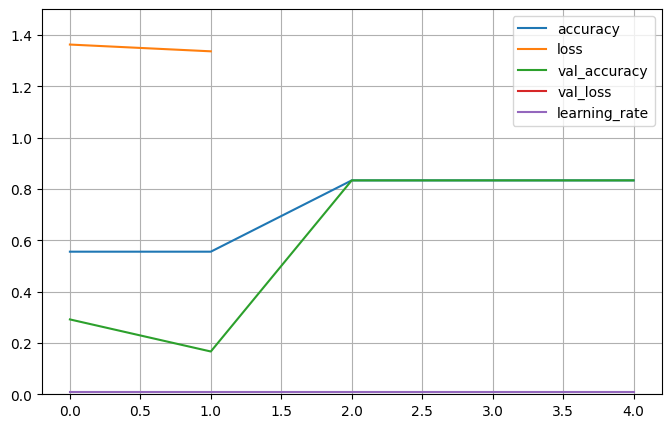

In [15]:
# Plot Metrics
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
plt.show()